In [305]:
%load_ext autoreload
%autoreload 2
import os

try:
    print(os.getcwd())
    os.chdir("../../rug-hr/")
    print(os.getcwd())
except:
    pass

import matplotlib.pyplot as plt
from skimage import transform
from PIL import Image, ImageFont, ImageDraw
from tqdm import tqdm

import numpy as np
from scipy.ndimage import label, center_of_mass
from scipy.spatial.distance import cdist
from utils.transforms import remove_ornaments



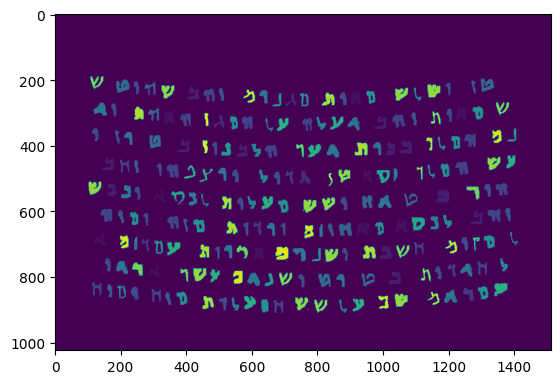

In [306]:
# show image
image = np.array(Image.open("experiments/11.png"))
plt.imshow(image)

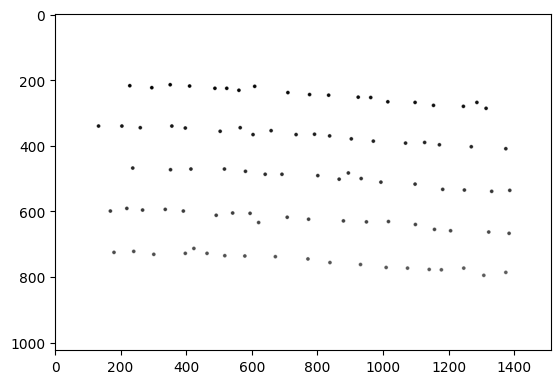

In [307]:
def find_centers_of_characters(img: np.ndarray, distance_threshold=0):
    unique_values = np.unique(img)
    unique_values = unique_values[unique_values != 0]  # Exclude background value (0)

    centers = []

    for value in unique_values:
        binary_img = np.where(img == value, 1, 0)

        # Label connected components
        labeled_img, num_components = label(binary_img)

        # Calculate centers
        value_centers = center_of_mass(binary_img, labeled_img, range(1, num_components + 1))

        # Convert coordinates to integers
        int_centers = [tuple(map(int, center)) for center in value_centers]

        # Merge centers that are close together
        merged_centers = []
        for idx, center in enumerate(int_centers):
            if center in merged_centers:
                continue

            # Find the centers that are within the distance threshold
            distances = cdist([center], int_centers)[0]
            close_centers_idx = np.where(distances <= distance_threshold)[0]

            # Calculate the new combined center
            new_center = np.mean([int_centers[i] for i in close_centers_idx], axis=0)
            merged_centers.append(tuple(map(int, new_center)))

        centers.extend(merged_centers)

    return centers


masks_folder = "experiments/Masks/"
masks = os.listdir(masks_folder)
random_mask = np.random.choice(masks)
image = np.array(Image.open(masks_folder + random_mask))

image_binary = np.where(image > 0, 1, 0)
image_without_ornaments = remove_ornaments(image_binary)

centers = find_centers_of_characters(image_without_ornaments)

# Place circles on the centers of the characters
# img = Image.open(masks_folder + random_mask).convert("RGB")  # Convert image to RGB format
img = Image.new("RGB", (image.shape[1], image.shape[0]), (255, 255, 255))
img = np.array(img)
img[img == 0] = 255
img = Image.fromarray(img)

draw = ImageDraw.Draw(img)
for center in centers:
    draw.ellipse((center[1] - 5, center[0] - 5, center[1] + 5, center[0] + 5), fill=(255, 0, 0))
plt.imshow(img)


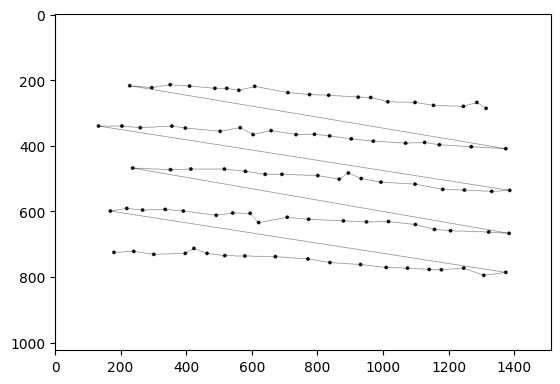

No starting point found


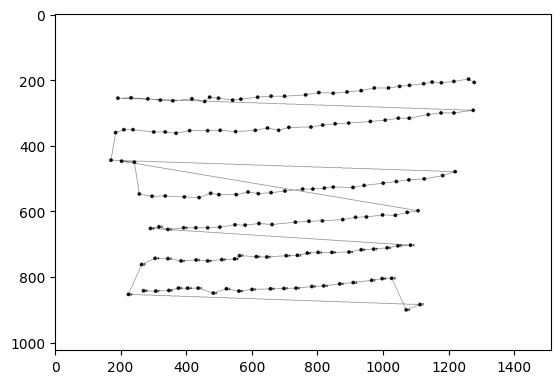